## Applying data analysis and machine learning algorithms to predict price of diamonds
Loading standard libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

import diamonds from csv file

In [4]:
data = pd.read_csv('diamonds.csv')
data = data.reindex(columns=['carat','color','cut','clarity','depth','table','price','x','y','z'])
data.head()

,carat,color,cut,clarity,depth,table,price,x,y,z
0,0.23,E,Ideal,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,E,Premium,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,E,Good,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,I,Premium,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,J,Good,SI2,63.3,58.0,335,4.34,4.35,2.75


Assign numbers to categorical properties

In [5]:
data.cut = pd.Categorical(data.cut)
data['cut']=data['cut'].cat.codes

data.color = pd.Categorical(data.color)
data['color']=data['color'].cat.codes

data.clarity = pd.Categorical(data.clarity)
data['clarity']=data['clarity'].cat.codes
data.head()

,carat,color,cut,clarity,depth,table,price,x,y,z
0,0.23,1,2,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,1,3,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,5,3,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,6,1,3,63.3,58.0,335,4.34,4.35,2.75


### Can we predict the price of diamonds if we know all the other parameters?

Let us first plot the scatter plots of all the parameters against each other to see if there is some basic linear relationship between any of the parameters.

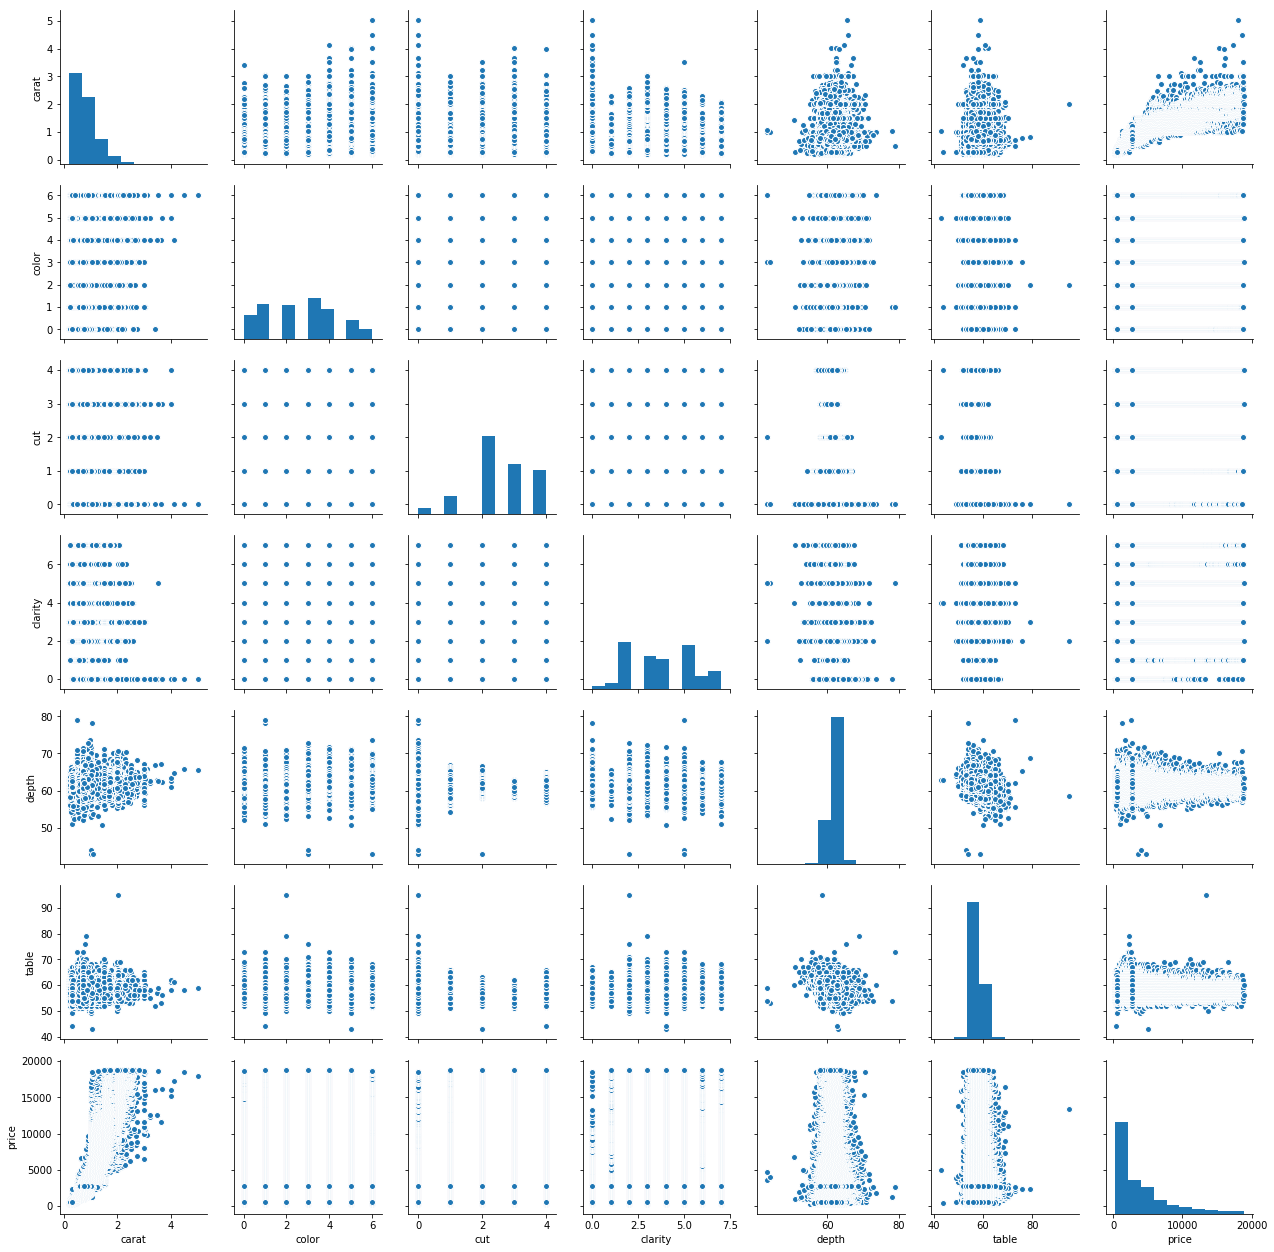

In [9]:
sns.pairplot(data[['carat','color','cut','clarity','depth','table','price']]);

At first glance, there seems to be a linear relationship between price and the carat of the diamonds. 

### Multiple Linear Regression
We will now try to fit a linear regression to the above data.
But before that let us do some basic statistical analysis using statsmodel 

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
stats = smf.ols('price ~ carat + color + cut + clarity + depth + table + x + y + z', data).fit()
stats.summary().tables[1]

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6e+04,411.237,38.895,0.000,1.52e+04,1.68e+04
carat,1.098e+04,57.590,190.630,0.000,1.09e+04,1.11e+04
color,-266.4524,3.590,-74.214,0.000,-273.489,-259.415
cut,70.6913,5.812,12.163,0.000,59.300,82.083
clarity,287.8468,3.488,82.535,0.000,281.011,294.682
depth,-154.2983,5.043,-30.596,0.000,-164.183,-144.414
table,-93.3162,2.808,-33.238,0.000,-98.819,-87.813
x,-1184.9255,39.036,-30.355,0.000,-1261.436,-1108.415
y,47.2688,23.068,2.049,0.040,2.056,92.482
z,-1.6881,40.038,-0.042,0.966,-80.162,76.786


From analysis of the p value, we can say that due to large value of the z (depth of diamond), it seems this
does not contribute towards the price of the diamond. 
The value of p for y too is greater than 0.01, so this too may not be important in final model.

### Training set and test set
Before we can apply any of the models, we will divide the total dataset into a training and test set. 
The diamond dataset has a total 53940 observations. It is good practice to randomize the dataset before dividing into the training and test set. Therefore we will create a random training set containing with about 70% of the observations and the remaining 30% will be the test set.

In [23]:
msk = np.random.rand(len(data)) < 0.7
train = data[msk]
test = data[~msk]
X_train = pd.DataFrame(train,columns=['carat','color','cut','clarity','depth','table','x','y','z'])
y_train = pd.DataFrame(train,columns=['price'])
X_test = pd.DataFrame(test,columns=['carat','color','cut','clarity','depth','table','x','y','z'])
y_test = pd.DataFrame(test,columns=['price'])

### Applying linear regression

In [24]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

Once the model is fitted. Let us use this to predict output of the same training input dataset and use the R2 parameter to check for accuracy of the fitted model.

In [25]:
predict_train = lm.predict(X_train)
r2_score(y_train,predict_train)

0.8834142570304562

Text(0,0.5,u'y_train')

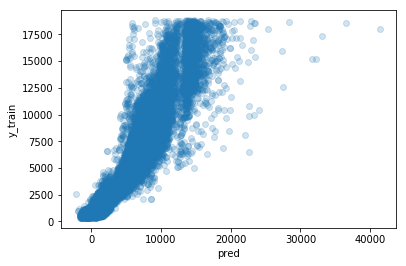

In [47]:
plt.scatter(predict_train,y_train['price'],alpha=0.2)
plt.xlabel('pred')
plt.ylabel('y_train')

The R2 values suggests that this is not a very good fit. But lets see how this model works on the validation set

In [32]:
predict_test = lm.predict(X_test)
r2_score(y_test,predict_test)

0.888542152771984

Text(0,0.5,u'y_test')

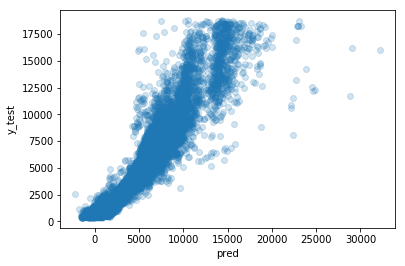

In [48]:
plt.scatter(predict_test,y_test['price'],alpha=0.2)
plt.xlabel('pred')
plt.ylabel('y_test')

So the model performs similarly on the test data too. The R^2 value, though not very high, is OK!

Let us try using Support Vector Regression 

### Support Vector Machine
First we will try the Linear SVM

In [27]:
from sklearn import svm
sv = svm.LinearSVR()

In [29]:
model2 = sv.fit(X_train,y_train)
sv.score(X_train,y_train)

0.7793024561259654

In [30]:
sv.score(X_test,y_test)

0.7806150187113774

Based on the R2 values of the SVM and the Linear Regression, looks like linear models are not performing that well. So let us try the Non Linear SVM.

### Non Linear Support Vector Machine 

In [34]:
sv = svm.SVR()
model3 = sv.fit(X_train,y_train)
sv.score(X_train,y_train)

0.26544281914792156

The score for the nonlinear SVM is even poorer. Lets try some other nonlinear method.
How about...

### Decision Trees

In [35]:
from sklearn import tree
tr = tree.DecisionTreeRegressor()

In [36]:
model4 = tr.fit(X_train,y_train)
tr.score(X_train,y_train)

0.9999958992820857

Text(0,0.5,u'y_train')

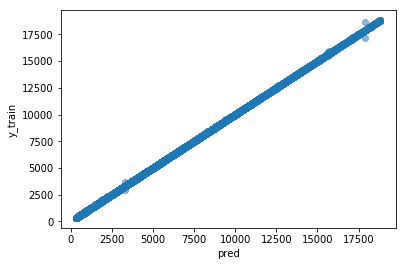

In [44]:
pred = tr.predict(X_train)
plt.scatter(pred, y_train['price'], alpha=0.5)
plt.xlabel('pred')
plt.ylabel('y_train')

### Wow! this is great. But let us see how this looks on the test data

In [37]:
tr.score(X_test,y_test)

0.9627463776137064

Text(0,0.5,u'y_test')

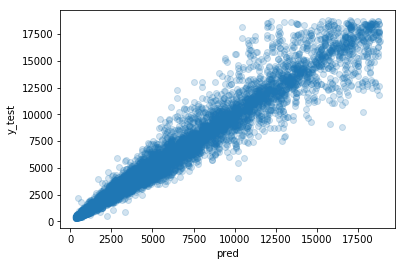

In [46]:
pred = tr.predict(X_test)
plt.scatter(pred, y_test['price'], alpha=0.2)
plt.xlabel('pred')
plt.ylabel('y_test')

### Great!! Seems like the decision is the best performing amongst the ones we have tried so far